# Time series Forecasting of ARCH CAPITAL GROUP stock price

In [19]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Reading the data

In [20]:
dateparse = lambda dates : pd.datetime.strptime(dates, "%Y-%m-%d")
stock = pd.read_csv("acgl.us.txt", index_col="Date", parse_dates=["Date"], date_parser=dateparse).fillna(0)
stock

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...
2017-11-06,94.490,95.650,94.020,95.550,420192,0
2017-11-07,95.860,95.950,95.200,95.560,464011,0
2017-11-08,95.410,95.900,94.890,95.450,471756,0


Text(0.5, 1.0, 'Closing price graph')

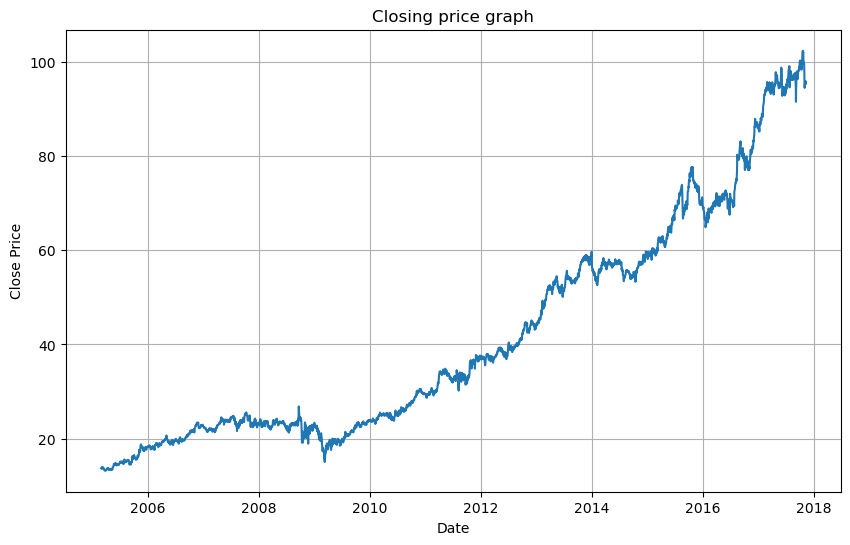

In [21]:
# Plotting the close Price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.plot(stock["Close"])
plt.title("Closing price graph")

<Axes: ylabel='Density'>

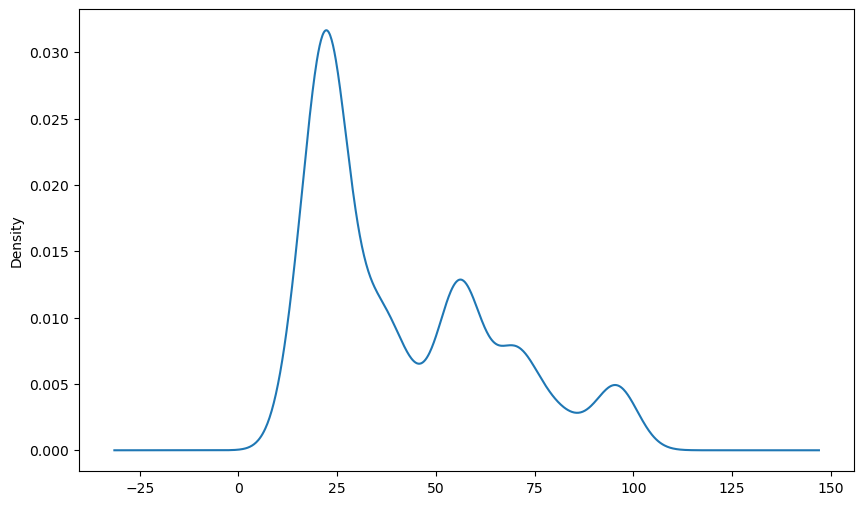

In [22]:
# Distribution of dataset
df_close = stock["Close"]
df_close.plot(kind="kde")

## Stationarity Test

The Augmented Dickey-Fuller test :
* $H_0$ : The time series has a unit root, meaning it is non-stationary.
* $H_a$ : The time series does not have a unit root, meaning it is stationary.

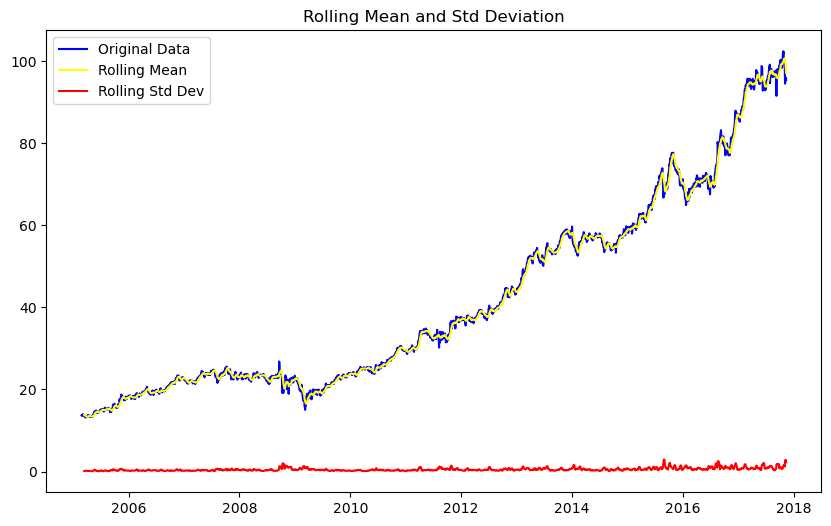

Results of Dickey-Fuller Test
Test Statistics              1.374899
p-value                      0.996997
No. of Lags used             5.000000
Number of observations    3195.000000
critical value (1%)         -3.432398
critical value (5%)         -2.862445
critical value (10%)        -2.567252
dtype: float64


In [23]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics of this data
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plotting the rolling statistics
    plt.plot(timeseries, color='blue', label='Original Data')
    plt.plot(rolmean, color="yellow", label="Rolling Mean")
    plt.plot(rolstd, color="red", label="Rolling Std Dev")
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Deviation')
    plt.show(block=False)

    print("Results of Dickey-Fuller Test")
    adft =  adfuller(timeseries, autolag="AIC")
    
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of Lags used', 'Number of observations'])

    for key, values in adft[4].items():
        output['critical value (%s) ' %key] = values
    print(output)

test_stationarity(df_close)

* p-value of is greater than 0.99, which means we Fail to Reject the NULL hypothesis, the Time series is non-stationary
* Therefore we need to remove Seasonality from the Time series.

## Remove Stationarity

<Figure size 1000x600 with 0 Axes>

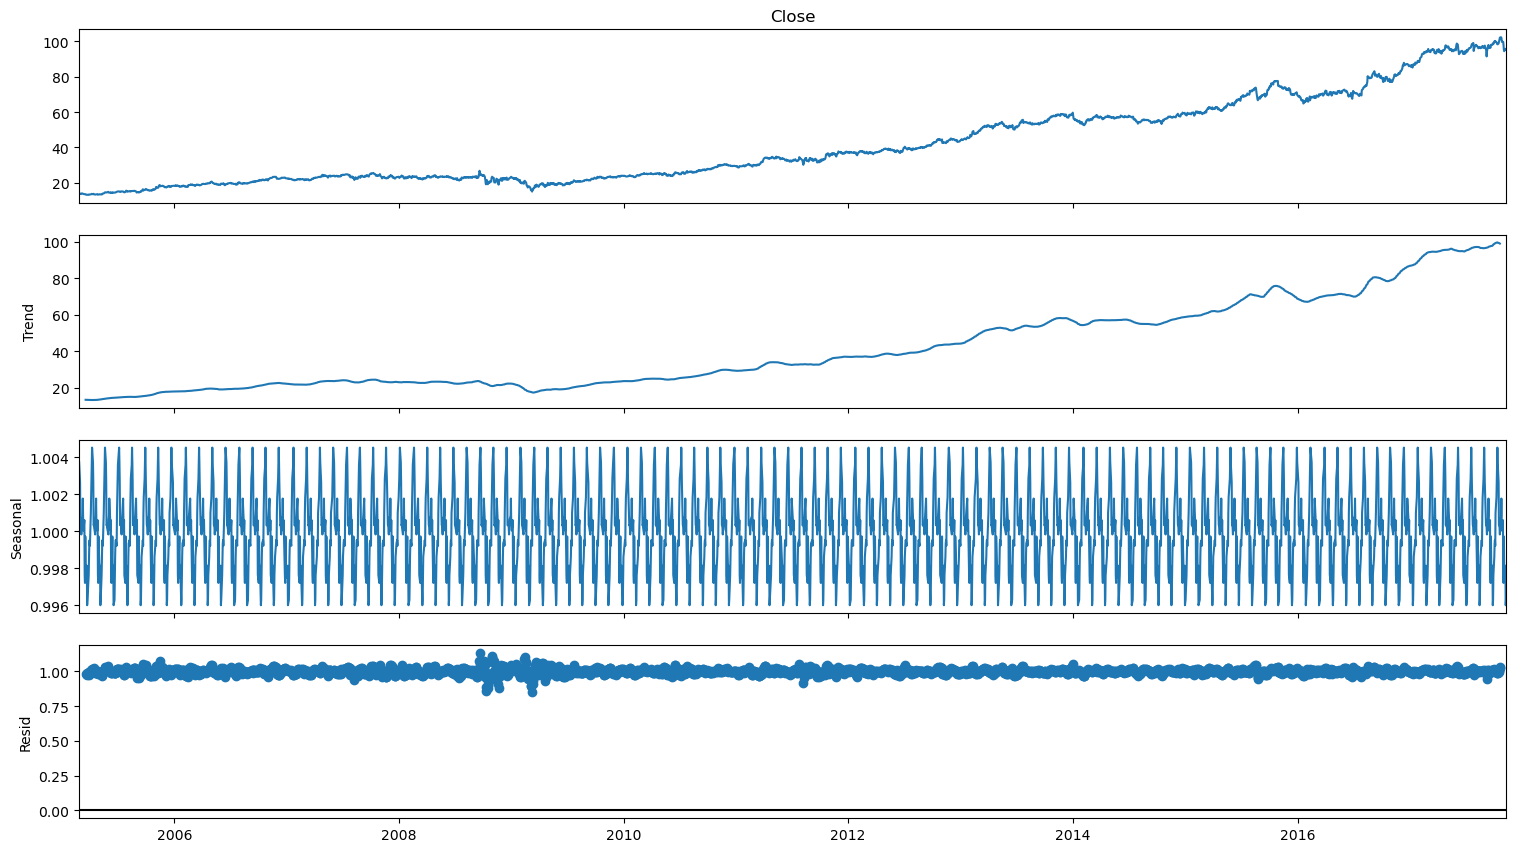

In [24]:
# To Seperate  the trend and the Seasonality from the Time Series,
# we can decompose the series using the following code

result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


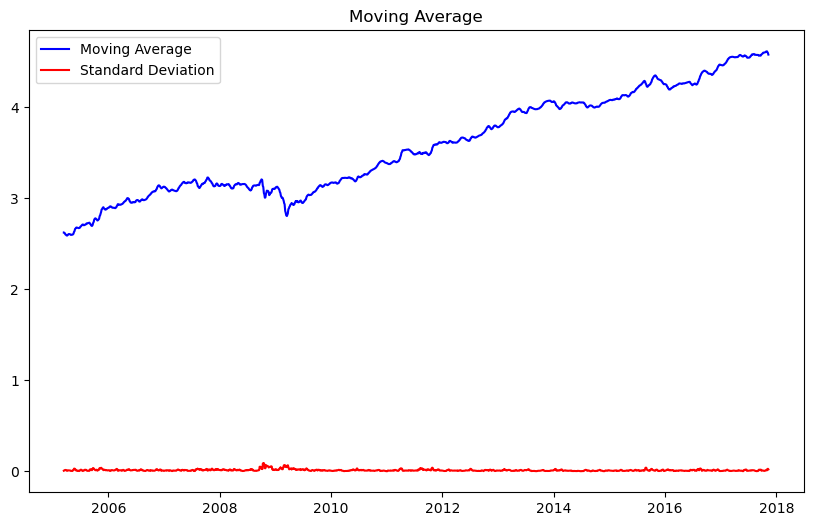

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.legend(loc='best')
plt.title("Moving Average")
plt.plot(moving_avg, color='blue', label='Moving Average')
plt.plot(std_dev, color='red', label='Standard Deviation')
plt.legend()
plt.show()

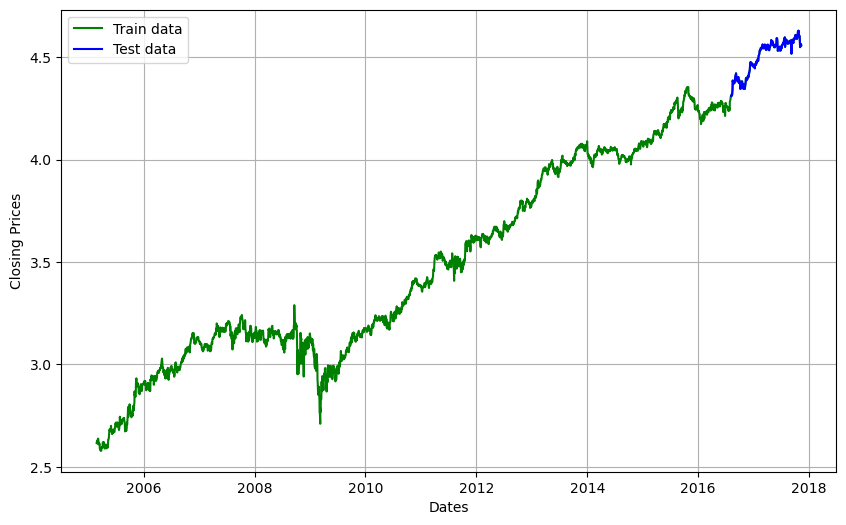

In [26]:
# Split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Model creation

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=1.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=1.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.52 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 10.490 seconds
  

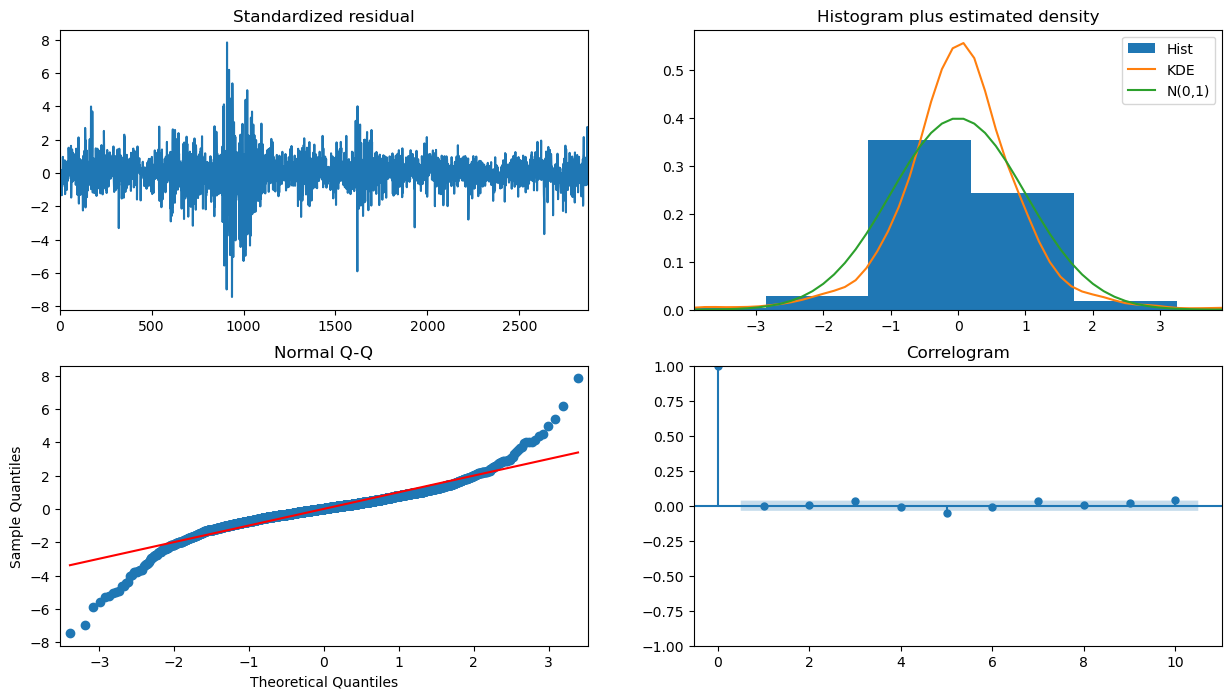

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


## Forecasting using the Model

In [28]:
# Modeling
# Build Model

model = sm.tsa.ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2877
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8264.031
Date:                Wed, 03 Apr 2024   AIC                         -16522.061
Time:                        12:46:24   BIC                         -16504.169
Sample:                             0   HQIC                        -16515.612
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1228      0.081      1.512      0.131      -0.036       0.282
ma.L1         -0.2360      0.076     -3.086      0.002      -0.386      -0.086
sigma2         0.0002   2.25e-06     83.046      0.0

In [29]:
# Forecast
result = fitted.get_forecast(321, alpha =0.05).summary_frame()
print(result)



Close      mean   mean_se  mean_ci_lower  mean_ci_upper
2877   4.304728  0.013672       4.277931       4.331524
2878   4.304676  0.018273       4.268861       4.340491
2879   4.304670  0.021825       4.261893       4.347447
2880   4.304669  0.024864       4.255937       4.353401
2881   4.304669  0.027568       4.250636       4.358702
...         ...       ...            ...            ...
3193   4.304669  0.212129       3.888904       4.720435
3194   4.304669  0.212463       3.888249       4.721089
3195   4.304669  0.212797       3.887596       4.721743
3196   4.304669  0.213129       3.886943       4.722395
3197   4.304669  0.213462       3.886292       4.723047

[321 rows x 4 columns]


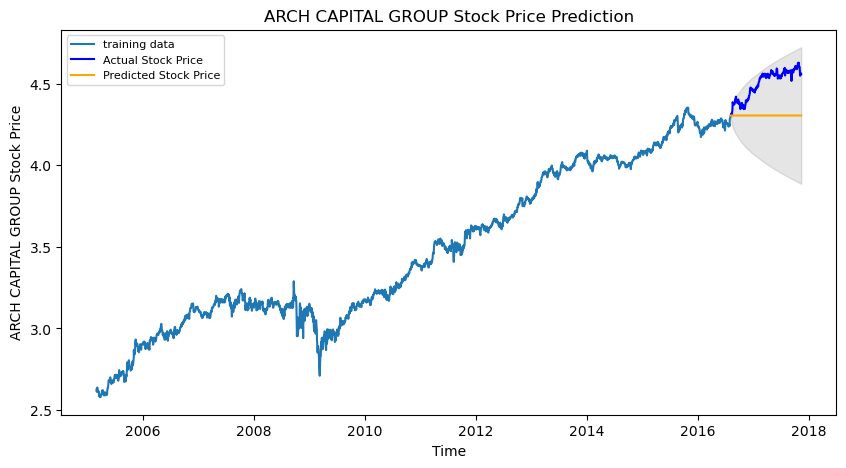

In [30]:
# Make as pandas series
fc_series = pd.Series(result['mean'].values, index=test_data.index)
lower_series = pd.Series(result['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(result['mean_ci_upper'].values, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Model Performance

In [32]:
mse = mean_squared_error(test_data, fc_series)
print("MSE:" + str(mse))
mae = mean_absolute_error(test_data, fc_series)
print("MAE:" + str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print("RMSE:" + str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print("MAPE:" + str(mape))

MSE:0.04630238960685226
MAE:0.1976517356022736
RMSE:0.2151799005642773
MAPE:0.04355419521256183
